In [67]:
# Import dependencies
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, LeakyReLU
from keras.activations import tanh
from keras.optimizers import Adam
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [3]:
df = pd.read_csv('london_weather.csv')

In [30]:
df.head()

,mean_temp,max_temp,min_temp,cloud_cover,sunshine,global_radiation,precipitation,pressure,snow_depth
date,,,,,,,,,
1979-01-01,-4.1,2.3,-7.5,2.0,7.0,52.0,0.4,101.90,9.0
1979-01-02,-2.6,1.6,-7.5,6.0,1.7,27.0,0.0,102.53,8.0
1979-01-03,-2.8,1.3,-7.2,5.0,0.0,13.0,0.0,102.05,4.0
1979-01-04,-2.6,-0.3,-6.5,8.0,0.0,13.0,0.0,100.84,2.0
1979-01-05,-0.8,5.6,-1.4,6.0,2.0,29.0,0.0,102.25,1.0


In [29]:
df.shape

(13843, 9)

In [5]:
df = df.reindex(columns = ['date', 'mean_temp', 'max_temp', 'min_temp', 'cloud_cover', 'sunshine', 
                           'global_radiation', 'precipitation', 'pressure', 'snow_depth'])

In [6]:
# Convert pressure from Pa to KPa
df['pressure'] = df['pressure'] / 1000

In [7]:
df['date'] = pd.to_datetime(df['date'], format = '%Y%m%d')

df = df.set_index('date')

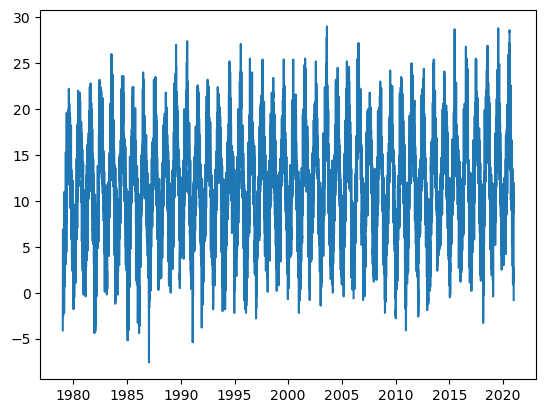

In [8]:
plt.plot(df.index, df['mean_temp'])

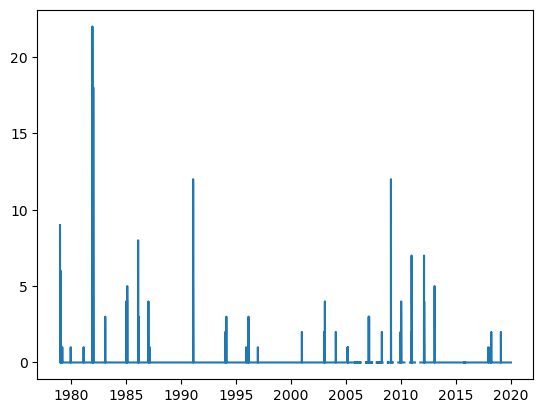

In [9]:
plt.plot(df.index, df['snow_depth'])

In [10]:
# Count NaN values in each column
nan_counts = df.isna().sum()

for col, count in nan_counts.items():
    print(f'{col}: {count}')

mean_temp: 36
max_temp: 6
min_temp: 2
cloud_cover: 19
sunshine: 0
global_radiation: 19
precipitation: 6
pressure: 4
snow_depth: 1441


In [11]:
df = df.dropna()

print(df.shape)

(13843, 9)


In [42]:
split_ratio = 13849 * 8//10
print(split_ratio)

11079


In [43]:
df_train = df[:split_ratio]
df_test = df[split_ratio:]

In [58]:
y_test = df_test['mean_temp'].values

In [60]:
y_test

array([19.1, 16.8, 17.1, ...,  8.7,  6.5,  7.1])

# Data preprocessing

In [12]:
# Create a scaling object
scaler = StandardScaler()

# Fit scaler to data
scaler.fit(df)

# Scale everything
scaled_data = scaler.fit_transform(df)

In [13]:
scaled_data.shape

(13843, 9)

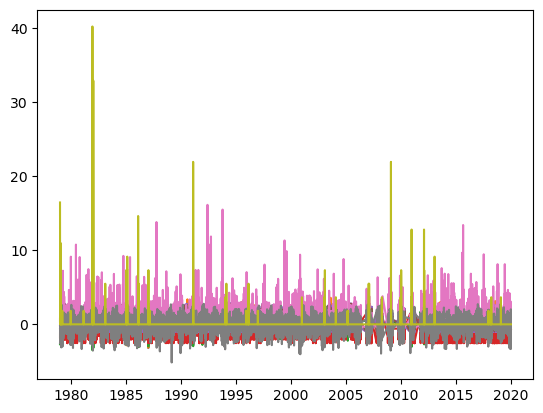

In [17]:
plt.plot(df.index, scaled_data)
plt.show()

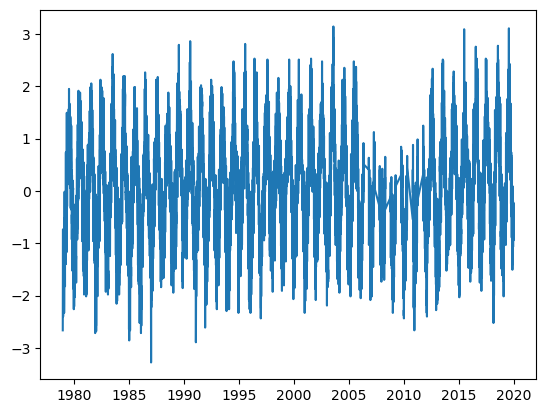

In [18]:
plt.plot(df.index, scaled_data[:,0])

Note that the errant 35+ data comes from the snowfall, which we will keep in our data for now and see if that impacts the training of our model

In [44]:
# Create the training and testing data using an 80-20 split
X_train = scaled_data[:split_ratio, 1:]
y_train = scaled_data[:split_ratio, 0]

X_test = scaled_data[split_ratio:, 1:]
y_test = scaled_data[split_ratio:, 0]

In [45]:
model = Sequential([
    Dense(64, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(1)
])

In [46]:
optimizer = tf.keras.optimizers.Adam()

model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['mean_absolute_error'])

In [47]:
history = model.fit(X_train, y_train, epochs = 50)

Epoch 1/50
347/347 [==============================] - 1s 2ms/step - loss: 0.0593 - mean_absolute_error: 0.1609
Epoch 2/50
347/347 [==============================] - 0s 1ms/step - loss: 0.0265 - mean_absolute_error: 0.1253
Epoch 3/50
347/347 [==============================] - 0s 1ms/step - loss: 0.0246 - mean_absolute_error: 0.1209
Epoch 4/50
347/347 [==============================] - 0s 1ms/step - loss: 0.0232 - mean_absolute_error: 0.1187
Epoch 5/50
347/347 [==============================] - 0s 1ms/step - loss: 0.0233 - mean_absolute_error: 0.1184
Epoch 6/50
347/347 [==============================] - 0s 1ms/step - loss: 0.0229 - mean_absolute_error: 0.1181
Epoch 7/50
347/347 [==============================] - 0s 1ms/step - loss: 0.0228 - mean_absolute_error: 0.1173
Epoch 8/50
347/347 [==============================] - 0s 1ms/step - loss: 0.0225 - mean_absolute_error: 0.1169
Epoch 9/50
347/347 [==============================] - 0s 1ms/step - loss: 0.0225 - mean_absolute_error: 0.1165
E

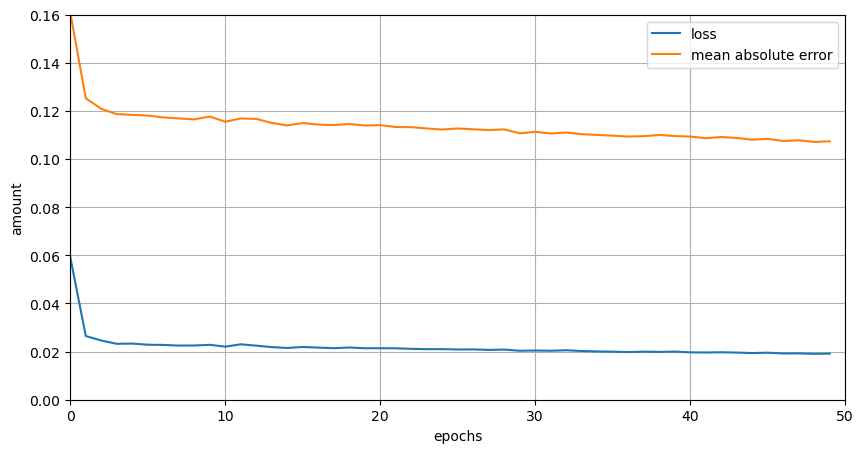

In [48]:
plt.figure(figsize = (10,5))
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['mean_absolute_error'], label = 'mean absolute error')
plt.xlabel('epochs')
plt.ylabel('amount')
plt.ylim(0,0.16)
plt.xlim(0,50)
plt.grid(True)
plt.legend()

In [49]:
model.evaluate(X_test, y_test)

87/87 [==============================] - 0s 1ms/step - loss: 0.0314 - mean_absolute_error: 0.1316


[0.03135561943054199, 0.13157570362091064]

In [50]:
y_pred_on_test = model.predict(X_test)

y_sim = np.zeros(shape = (len(y_pred_on_test), df.shape[1]))
# assign predicted values in the right field
y_sim[:,0] = y_pred_on_test[:, 0]
# Unscale
y_pred_on_test = scaler.inverse_transform(y_sim)[:,0]
y_pred_on_test = np.reshape(y_pred_on_test, (len(y_pred_on_test), 1))

87/87 [==============================] - 0s 819us/step


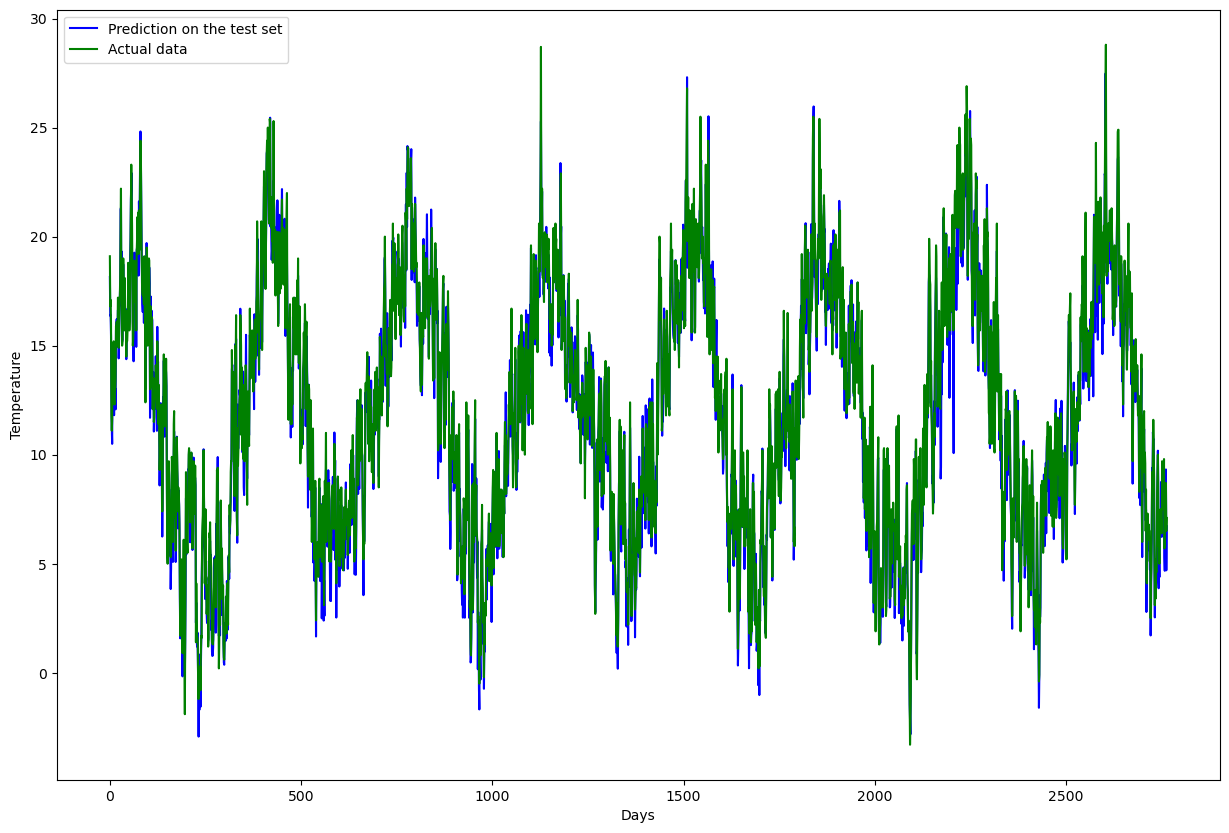

In [61]:
plt.figure(figsize = (15,10))
plt.plot(y_pred_on_test, color = 'b', label = 'Prediction on the test set')
plt.plot(y_test, color = 'g', label = 'Actual data')
plt.xlabel('Days')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [62]:
print(y_pred_on_test.shape)
print(y_test.shape)

(2764, 1)
(2764,)


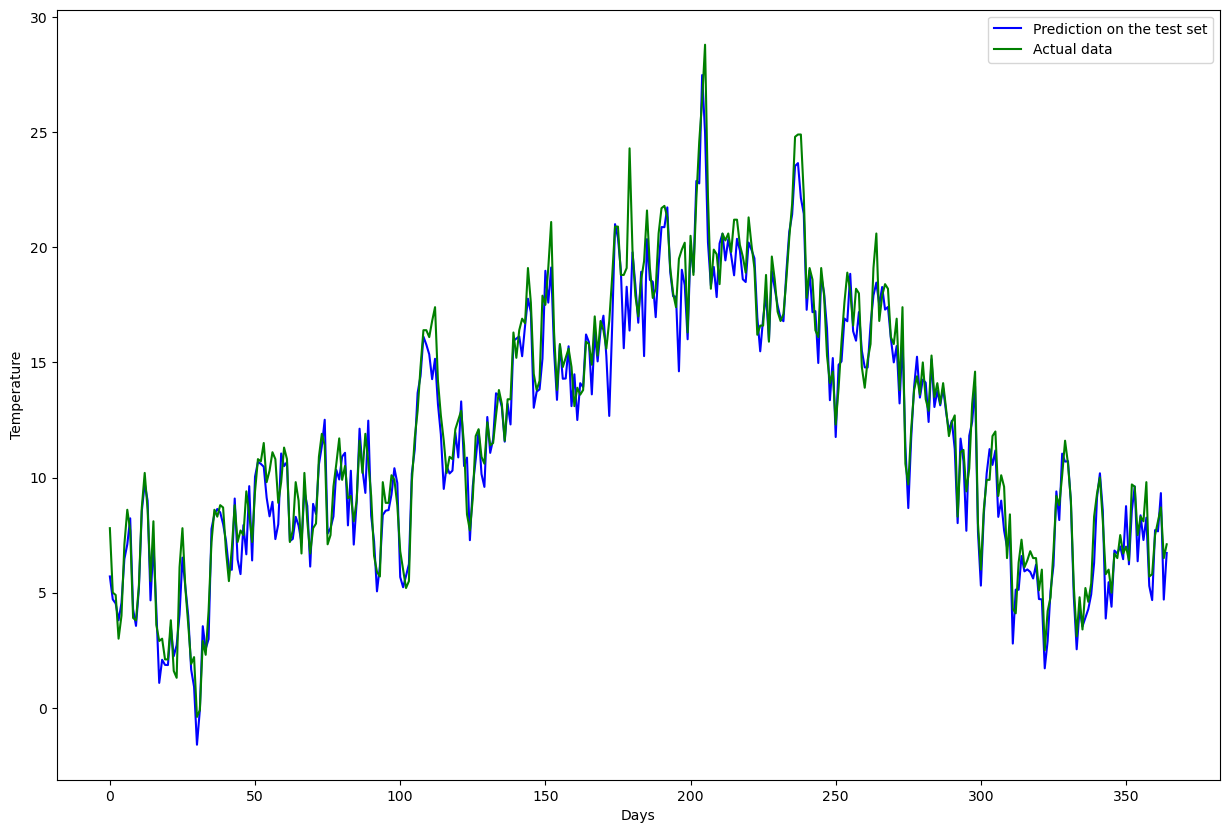

In [64]:
plt.figure(figsize = (15,10))
plt.plot(y_pred_on_test[(2764-365):], color = 'b', label = 'Prediction on the test set')
plt.plot(y_test[(2764-365):], color = 'g', label = 'Actual data')
plt.xlabel('Days')
plt.ylabel('Temperature')
plt.legend()
plt.show()

# Altering parameters

In [98]:
hyperparameters = {
    'hidden_layers': [2, 3, 4, 5],
    'hidden_units': [16, 32, 64, 128],
    'activation_func': ['tanh', LeakyReLU, 'relu'],
    'alpha': [0.01, 0.25, 0.5, 0.75, 1],
    'learning_rate': [0.2, 0.1, 0.075, 0.5]
}

In [ ]:
units = [16,32,64,128]
layers = [2,3,4,5]

In [102]:
def create_model(hidden_layers, hidden_units, activation_func, alpha, learning_rate):
    model = Sequential()
    for i in range(hidden_layers-1):
        if activation_func == 'LeakyReLU':
            model.add(Dense(units=hidden_units, activation= LeakyReLU(alpha = alpha)))
        else:
            model.add(Dense(units=hidden_units, activation=activation_func))
    model.add(Dense(units = 1, activation='softmax'))
    optimizer = Adam(learning_rate = learning_rate)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_absolute_error'])
    return model

In [108]:
def fit_evaluate_model(model):
    model.fit(X_train, y_train)
    loss, mean_absolute_error = model.evaluate(X_test, y_test, verbose=0)
    return loss, mean_absolute_error

In [112]:
results = []

for hidden_layers in hyperparameters['hidden_layers']:
    for hidden_units in hyperparameters['hidden_units']:
        for activation_func in hyperparameters['activation_func']:
            for alpha in hyperparameters['alpha']:
                for learning_rate in hyperparameters['learning_rate']:
                    model = create_model(hidden_layers=hidden_layers, hidden_units=hidden_units, activation_func=activation_func, alpha=alpha, learning_rate=learning_rate)
                    loss, mean_absolute_error = fit_evaluate_model(model)
                    results.append((hidden_layers, hidden_units, activation_func, alpha, learning_rate, loss, mean_absolute_error))
for hidden_layers, hidden_units, activation_func, alpha, learning_rate, loss, accuracy in results:
    print('Hidden Layers: {}, Hidden Units: {}, Activation Function: {}, Alpha: {}, Learning Rate: {}, Loss: {:.2f}, mean_absolute_error: {:.2f}%'.format(hidden_layers, hidden_units, activation_func, alpha, learning_rate, loss, accuracy*100))

In [ ]:
for units in units:
    for num_layers in layers:
        for activation in activation:
            if activation = LeakyReLU:
                for alpha in alpha:
                    leakyReLU = LeakyReLU(alpha = alpha)
            

In [ ]:
optimizer = optimizer = tf.keras.optimizers.Adam()

model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['mean_absolute_error'])

In [77]:
create_model(layers[2], units[3], activation[1](alpha = 0.1), learning_rate[2])

In [87]:
units[0]

16

In [114]:

# Define the model function
def create_model(input_shape, num_classes, hidden_layers, hidden_units, activation_func, alpha, learning_rate):
    model = Sequential()
    if activation_func == 'LeakyReLU':
        model.add(Dense(units=hidden_units, input_shape=input_shape))
        model.add(LeakyReLU(alpha=alpha))
    else:
        model.add(Dense(units=hidden_units, input_shape=input_shape, activation=activation_func))
    for i in range(hidden_layers-1):
        if activation_func == 'LeakyReLU':
            model.add(Dense(units=hidden_units))
            model.add(LeakyReLU(alpha=alpha))
        else:
            model.add(Dense(units=hidden_units, activation=activation_func))
    model.add(Dense(units=num_classes, activation='softmax'))
    optimizer = Adam(lr=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Define the function to fit and evaluate the model
def fit_evaluate_model(model, X_train, y_train, X_test, y_test, batch_size, epochs):
    model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0)
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    return loss, accuracy

# Example usage
hyperparameters = {
    'hidden_layers': [2, 3, 4, 5],
    'hidden_units': [16, 32, 64, 128],
    'activation_func': ['tanh', LeakyReLU, 'relu'],
    'alpha': [0.01, 0.25, 0.5, 0.75, 1],
    'learning_rate': [0.2, 0.1, 0.075, 0.5]
}
results = []
for hidden_layers in hyperparameters['hidden_layers']:
    for hidden_units in hyperparameters['hidden_units']:
        for activation_func in hyperparameters['activation_func']:
            for alpha in hyperparameters['alpha']:
                for learning_rate in hyperparameters['learning_rate']:
                    model = create_model(input_shape=X_train.shape[1:], num_classes=num_classes, hidden_layers=hidden_layers, hidden_units=hidden_units, activation_func=activation_func, alpha=alpha, learning_rate=learning_rate)
                    loss, accuracy = fit_evaluate_model(model, X_train, y_train, X_test, y_test, batch_size=32, epochs=10)
                    results.append((hidden_layers, hidden_units, activation_func, alpha, learning_rate, loss, accuracy))
for hidden_layers, hidden_units, activation_func, alpha, learning_rate, loss, accuracy in results:
    print('Hidden Layers: {}, Hidden Units: {}, Activation Function: {}, Alpha: {}, Learning Rate: {}, Loss: {:.2f}, Accuracy: {:.2f}%'.format(hidden_layers, hidden_units, activation_func, alpha, learning_rate, loss, accuracy*100))

NameError: name 'num_classes' is not defined